## Create a Knapsack Problem Instance

In [3]:
from knapsack import Knapsack
from WCGGA import run_WCGGA
from CGGA_New import run_CGGA
# Create an instance of a Knapsack problem
p_file = "Knapsack_Problems/problemInstances/n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300/test.in"
opt_file = "Knapsack_Problems/optima.csv"
knapsack = Knapsack(p_file, opt_file)

n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300
n_800_c_1000000_

Starting Benchmark: 2 seeds x 2 Algos x 1 Problems
Running WCGGA | Problem: n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300 | Seed: 42...
Starting Deterministic Crowding Evolution...
Gen 0: P1A=1007349  P1B=1007169  P2A=1007071  P2B=1007002  P3A=1006951  P3B=1007275  P4A=1007277  P4B=1007349  
Gen 1: P1A=1007369  P1B=1007445  P2A=1007164  P2B=1007290  P3A=1007084  P3B=1007275  P4A=1007348  P4B=1007349  
Gen 2: P1A=1007369  P1B=1007445  P2A=1007337  P2B=1007321  P3A=1007182  P3B=1007275  P4A=1007348  P4B=1007349  
Gen 3: P1A=1007369  P1B=1007445  P2A=1007337  P2B=1007321  P3A=1007318  P3B=1007275  P4A=1007514  P4B=1007349  
Gen 4: P1A=1007369  P1B=1007445  P2A=1007337  P2B=1007321  P3A=1007359  P3B=1007275  P4A=1007514  P4B=1007349  
Gen 5: P1A=1007369  P1B=1007445  P2A=1007337  P2B=1007321  P3A=1007359  P3B=1007334  P4A=1007514  P4B=1007349  
Gen 6: P1A=1007369  P1B=1007445  P2A=1007337  P2B=1007321  P3A=1007359  P3B=1007334  P4A=1007514  P4B=1007349  
Gen 7: P1A=1007369  P1B=1007445  P2A=100

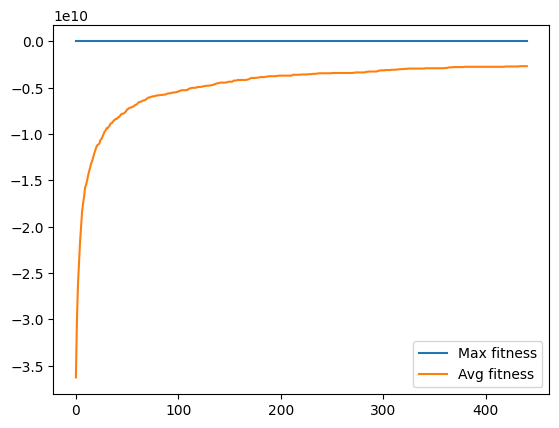

Running WCGGA | Problem: n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300 | Seed: 1013...
Starting Deterministic Crowding Evolution...
Gen 0: P1A=1007398  P1B=1007124  P2A=1007094  P2B=1007069  P3A=1007245  P3B=1007388  P4A=1006984  P4B=1007090  
Gen 1: P1A=1007398  P1B=1007124  P2A=1007431  P2B=1007333  P3A=1007245  P3B=1007388  P4A=1006984  P4B=1007288  
Gen 2: P1A=1007398  P1B=1007170  P2A=1007431  P2B=1007333  P3A=1007245  P3B=1007388  P4A=1007274  P4B=1007288  
Gen 3: P1A=1007398  P1B=1007219  P2A=1007431  P2B=1007389  P3A=1007245  P3B=1007388  P4A=1007434  P4B=1007288  
Gen 4: P1A=1007398  P1B=1007219  P2A=1007431  P2B=1007389  P3A=1007464  P3B=1007388  P4A=1007434  P4B=1007288  
Gen 5: P1A=1007398  P1B=1007219  P2A=1007431  P2B=1007389  P3A=1007464  P3B=1007388  P4A=1007434  P4B=1007288  
Gen 6: P1A=1007398  P1B=1007351  P2A=1007431  P2B=1007389  P3A=1007464  P3B=1007388  P4A=1007434  P4B=1007288  
Gen 7: P1A=1007398  P1B=1007519  P2A=1007431  P2B=1007389  P3A=1007513  P3B=1007388  P4A=

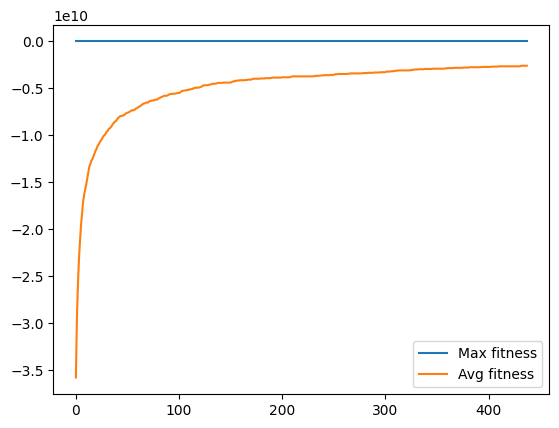

Running CGGA | Problem: n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300 | Seed: 42...
Starting Deterministic Crowding Evolution...
Gen 0: P1A=1007234  P1B=1006991  P2A=1007169  P2B=1007178  P3A=1007492  P3B=1007240  P4A=1007166  P4B=1006944  
Gen 1: P1A=1007234  P1B=1007257  P2A=1007514  P2B=1007178  P3A=1007492  P3B=1007240  P4A=1007353  P4B=1007012  
Gen 2: P1A=1007234  P1B=1007257  P2A=1007514  P2B=1007178  P3A=1007492  P3B=1007240  P4A=1007513  P4B=1007115  
Gen 3: P1A=1007234  P1B=1007257  P2A=1007514  P2B=1007353  P3A=1007492  P3B=1007240  P4A=1007513  P4B=1007115  
Gen 4: P1A=1007234  P1B=1007257  P2A=1007514  P2B=1007353  P3A=1007492  P3B=1007240  P4A=1007513  P4B=1007119  
Gen 5: P1A=1007234  P1B=1007257  P2A=1007514  P2B=1007353  P3A=1007492  P3B=1007240  P4A=1007513  P4B=1007119  
Gen 6: P1A=1007234  P1B=1007301  P2A=1007514  P2B=1007353  P3A=1007513  P3B=1007561  P4A=1007513  P4B=1007276  
Gen 7: P1A=1007234  P1B=1007301  P2A=1007514  P2B=1007353  P3A=1007513  P3B=1007561  P4A=100

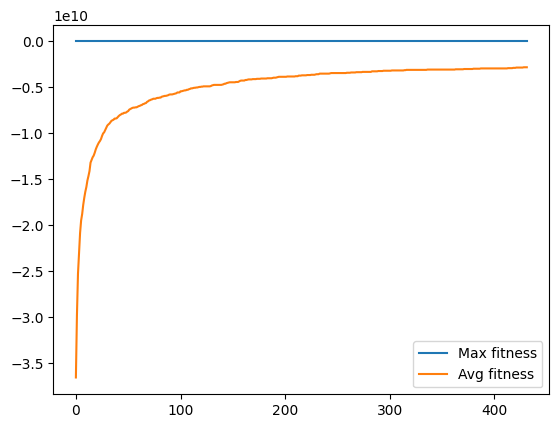

Running CGGA | Problem: n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300 | Seed: 1013...
Starting Deterministic Crowding Evolution...
Gen 0: P1A=1007363  P1B=1007238  P2A=1007271  P2B=1007227  P3A=1007236  P3B=1007192  P4A=1007281  P4B=1007013  
Gen 1: P1A=1007363  P1B=1007254  P2A=1007271  P2B=1007284  P3A=1007386  P3B=1007192  P4A=1007281  P4B=1007046  
Gen 2: P1A=1007363  P1B=1007415  P2A=1007271  P2B=1007284  P3A=1007386  P3B=1007192  P4A=1007300  P4B=1007105  
Gen 3: P1A=1007363  P1B=1007415  P2A=1007271  P2B=1007327  P3A=1007386  P3B=1007192  P4A=1007318  P4B=1007105  
Gen 4: P1A=1007363  P1B=1007415  P2A=1007317  P2B=1007327  P3A=1007386  P3B=1007192  P4A=1007318  P4B=1007105  
Gen 5: P1A=1007363  P1B=1007415  P2A=1007317  P2B=1007327  P3A=1007386  P3B=1007192  P4A=1007318  P4B=1007105  
Gen 6: P1A=1007363  P1B=1007415  P2A=1007380  P2B=1007327  P3A=1007386  P3B=1007192  P4A=1007318  P4B=1007179  
Gen 7: P1A=1007363  P1B=1007415  P2A=1007380  P2B=1007327  P3A=1007396  P3B=1007192  P4A=1

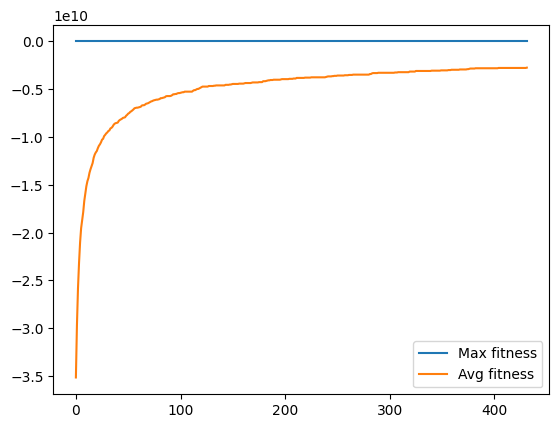

Benchmark Complete. Results saved to benchmark_results_20251211-154354.csv
                                                    count       mean  \
Algorithm Problem                                                      
CGGA      n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300    2.0  1007796.5   
WCGGA     n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300    2.0  1007767.5   

                                                          std        min  \
Algorithm Problem                                                          
CGGA      n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300  36.062446  1007771.0   
WCGGA     n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300   7.778175  1007762.0   

                                                           25%        50%  \
Algorithm Problem                                                           
CGGA      n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300  1007783.75  1007796.5   
WCGGA     n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300  1007764.75  1007767.5   

                      

In [4]:
import pandas as pd
import numpy as np
import time
from knapsack import Knapsack
# Import your actual functions
from WCGGA import run_WCGGA
from CGGA_New import run_CGGA

# 1. SETUP CONFIGURATION
PROBLEMS = [
    # Path, Optimal Value (found in optima.csv or known)
    ("Knapsack_Problems/problemInstances/n_800_c_1000000_g_6_f_0.1_eps_0.01_s_300/test.in", 1036114),
    # Add more instances here (Small, Medium, Large)
]

SEEDS = [42, 1013] # Ideally use range(30)
ALGORITHMS = ["WCGGA", "CGGA"]

# Common Parameters
PARAMS = {
    "pop_size": 2400,
    "max_time": 600, # 10 minutes per run
    "max_generations": 10000,
    "stagnation_limit": 75,
    "initialization_feasability": 0.3
}

results_data = []

print(f"Starting Benchmark: {len(SEEDS)} seeds x {len(ALGORITHMS)} Algos x {len(PROBLEMS)} Problems")

# 2. THE BENCHMARK LOOP
for p_path, optimal_value in PROBLEMS:
    # Initialize Problem
    knapsack = Knapsack(p_path)
    # Note: If your Knapsack init requires the optima file, include it.

    mutation_prob = 4.0 / len(knapsack)

    for algo_name in ALGORITHMS:
        for seed in SEEDS:
            print(f"Running {algo_name} | Problem: {p_path.split('/')[-2]} | Seed: {seed}...")

            start_wall_time = time.time()

            # Run the specific algorithm
            if algo_name == "WCGGA":
                res = run_WCGGA(
                    knapsack,
                    pop_size=PARAMS["pop_size"],
                    crossover_probability=1.0,
                    mutation_probability=mutation_prob,
                    max_time=PARAMS["max_time"],
                    max_generations=PARAMS["max_generations"],
                    stagnation_limit=PARAMS["stagnation_limit"],
                    initialization_feasability=PARAMS["initialization_feasability"],
                    random_seed=seed
                )
            else: # CGGA
                res = run_CGGA(
                    knapsack,
                    pop_size=PARAMS["pop_size"],
                    crossover_probability=1.0,
                    mutation_probability=mutation_prob,
                    max_time=PARAMS["max_time"],
                    max_generations=PARAMS["max_generations"],
                    stagnation_limit=PARAMS["stagnation_limit"],
                    initialization_feasability=PARAMS["initialization_feasability"],
                    migration_size=3,        # Specific to CGGA
                    migration_frequency=20,   # Specific to CGGA
                    random_seed=seed
                )

            end_wall_time = time.time()
            duration = end_wall_time - start_wall_time

            # Extract Metrics
            best_fitness = res['best_individual'].fitness.values[0]
            gap = ((optimal_value - best_fitness) / optimal_value) * 100

            # Save Record
            record = {
                "Algorithm": algo_name,
                "Problem": p_path.split('/')[-2], # Extracts folder name usually
                "Seed": seed,
                "Best_Fitness": best_fitness,
                "Optimal": optimal_value,
                "Gap_Percent": gap,
                "Time_Seconds": duration,
                "Generations_Run": len(res['max_values'])
            }
            results_data.append(record)

# 3. SAVE RESULTS
df = pd.DataFrame(results_data)
timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"benchmark_results_{timestamp}.csv"
df.to_csv(filename, index=False)

print(f"Benchmark Complete. Results saved to {filename}")
print(df.groupby(["Algorithm", "Problem"])["Best_Fitness"].describe())